In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.pdfigcapx.utils import extract_page_text_content, sort_by_most_common_value_desc
from selenium import webdriver
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

from src.pdfigcapx.html_content import HtmlPage

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
html_sample_1 = str(Path('../tests/data/htmls/page1.html').resolve())
html_sample_2 = str(Path('../tests/data/htmls/page2.html').resolve())
png_sample_1 = str(Path('../tests/data/htmls/page1.png').resolve())

page1 = extract_page_text_content(driver, html_sample_1)
page2 = extract_page_text_content(driver, html_sample_2)

In [44]:
MIN_LENGTH = 30

def draw_page_with_annotations(page: HtmlPage, png_path: str):
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)

  fig, ax = plt.subplots(dpi=150)

  x_lefts = []
  x_rights = []
  row_widths = []
  row_heights = []
  y_tops = []

  for text_box in page.text_boxes:
    if len(text_box.text) > MIN_LENGTH:
      x_lefts.append(text_box.x_top_left)
      row_heights.append(text_box.height)
      row_widths.append(text_box.width)
      y_tops.append(text_box.y_top_left)
      x_rights.append(text_box.x_top_right)
      edgecolor = 'b'
    else: 
      edgecolor = 'r'
    rect = patches.Rectangle((text_box.x_top_left, text_box.y_top_left), text_box.width, text_box.height, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
  
  text_y_range = (max(0, min(y_tops)), min(page.height, max(y_tops)))
  common_x_lefts = sort_by_most_common_value_desc(x_lefts)
  common_row_widths = sort_by_most_common_value_desc(row_widths)
  common_row_heights = sort_by_most_common_value_desc(row_heights)
  
  ax.plot([2, 2], [text_y_range[0], text_y_range[1]], color="y")
  ax.plot([common_x_lefts[0].value, common_x_lefts[0].value], [0, page.height], color="g")
  ax.imshow(page_image)

  return common_x_lefts, common_row_widths, common_row_heights, x_lefts, x_rights, text_y_range

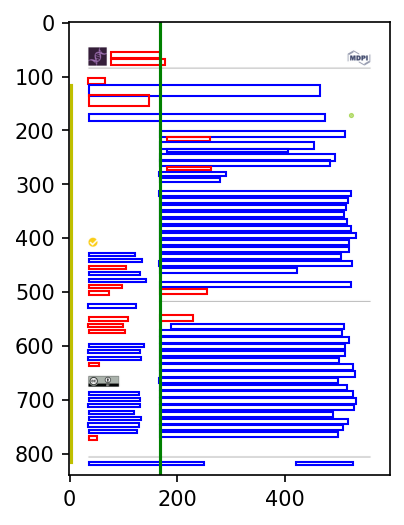

In [45]:
common_x_lefts, common_row_widths, common_row_heights, x_lefts, x_rights, text_y_range = draw_page_with_annotations(page1, png_sample_1)

In [25]:
common_x_lefts

[CountTuple(count=31, value=167),
 CountTuple(count=13, value=36),
 CountTuple(count=5, value=35),
 CountTuple(count=4, value=166),
 CountTuple(count=1, value=421),
 CountTuple(count=1, value=188),
 CountTuple(count=1, value=180)]

In [26]:
common_row_widths

[CountTuple(count=3, value=351),
 CountTuple(count=2, value=365),
 CountTuple(count=2, value=356),
 CountTuple(count=2, value=349),
 CountTuple(count=2, value=348),
 CountTuple(count=2, value=344),
 CountTuple(count=2, value=322),
 CountTuple(count=2, value=98),
 CountTuple(count=2, value=96),
 CountTuple(count=2, value=95),
 CountTuple(count=2, value=93),
 CountTuple(count=1, value=439),
 CountTuple(count=1, value=428),
 CountTuple(count=1, value=363),
 CountTuple(count=1, value=361),
 CountTuple(count=1, value=360),
 CountTuple(count=1, value=359),
 CountTuple(count=1, value=358),
 CountTuple(count=1, value=355),
 CountTuple(count=1, value=347),
 CountTuple(count=1, value=345),
 CountTuple(count=1, value=342),
 CountTuple(count=1, value=341),
 CountTuple(count=1, value=338),
 CountTuple(count=1, value=337),
 CountTuple(count=1, value=333),
 CountTuple(count=1, value=332),
 CountTuple(count=1, value=331),
 CountTuple(count=1, value=325),
 CountTuple(count=1, value=316),
 CountTuple(co

Take all the tuple of x_left points and counts, and merge them if the distance between them if smaller than BOX_DISTANCE

In [27]:
from src.pdfigcapx.html_content import CountTuple

BOX_DISTANCE = 10
i = 0
points_left = common_x_lefts.copy()
while i < len(points_left):
    j = i + 1
    while j < len(points_left):
        if abs(points_left[i].value - points_left[j].value) <= BOX_DISTANCE:
            points_left[i] = CountTuple(value=points_left[i].value, count=points_left[i].count + points_left[j].count)
            del points_left[j]
        else:
            j = j + 1
    i = i + 1
points_left = sorted(points_left, key=lambda x: x.count, reverse=True)

In [28]:
points_left

[CountTuple(count=35, value=167),
 CountTuple(count=18, value=36),
 CountTuple(count=2, value=188),
 CountTuple(count=1, value=421)]

Calculate columns length

In [33]:
first_x = points_left[0]
row_width = common_row_widths[0].value

if float(first_x.count) / len(points_left) > 0.75 or float(row_width) / page1.width > 0.5:
    number_columns = 1
    cols_starting_x = [first_x.value]
else:
    number_columns = 2

    for i in range(1, len(points_left)):
        if abs(points_left[i].value - first_x.value) > row_width:
            cols_starting_x = [min(points_left[i].value, first_x.value),
                        max(points_left[i].value, first_x.value)]
            break

In [34]:
number_columns, cols_starting_x

(1, [167])

In [100]:
page = page1
x_bar_left  = min(x_lefts)
x_bar_right = max(x_rights)
row_height = common_row_heights[0].value

left_bbox = None
right_bbox = None
top_bbox = None
down_bbox = None

# calculate the PDF layout
# why 20?
if x_bar_left > 0 and x_bar_left < 20 * row_height:
    left_bbox = [0, 0, x_bar_left, page.height]    
    right_bbox = [x_bar_right, 0, page.width, page.height]

    # what is 15?
    if text_y_range[0] < 15 * row_height and text_y_range[1] > 15 * row_height:
        top_bbox = [0, 0, page.width, text_y_range[0]]
        down_bbox = [0, text_y_range[1], page.width, page.height]
    else:
        top_bbox = [0, 0, page.width, row_height]
        down_bbox = [0, page.height - row_height, page.width, row_height]
else:
    left_bbox= [0, 0, row_height, page.height]
    right_bbox = [page.width - row_height,
                          0, row_height, page.height]
    top_bbox = [0, 0, page.width, row_height]
    down_bbox = [0, page.height -
                          row_height, page.width, row_height]

option 1


In [96]:
left_bbox, right_bbox, top_bbox, down_bbox

([0, 0, 35, 841], [532, 0, 595, 841], [0, 0, 595, 116], [0, 116, 595, 815])

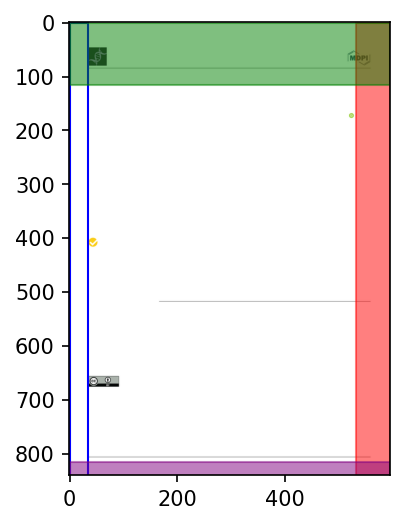

In [104]:
page_image = Image.open(png_sample_1)
page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)

fig, ax = plt.subplots(dpi=150)

left = patches.Rectangle((left_bbox[0], left_bbox[1]), 
                        left_bbox[2]-left_bbox[0],
                        left_bbox[3]-left_bbox[1], 
                        linewidth=1, edgecolor='b', facecolor='b', alpha=0.5)                        
ax.add_patch(left)

right = patches.Rectangle((right_bbox[0], right_bbox[1]), 
                        right_bbox[2]-right_bbox[0],
                        right_bbox[3]-right_bbox[1], 
                        linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
ax.add_patch(right)

top = patches.Rectangle((top_bbox[0], top_bbox[1]), 
                        top_bbox[2]+top_bbox[0],
                        top_bbox[3]+top_bbox[1], 
                        linewidth=1, edgecolor='g', facecolor='g', alpha=0.5)
ax.add_patch(top)

down = patches.Rectangle((down_bbox[0], down_bbox[1]), 
                        down_bbox[2]-down_bbox[0],
                        down_bbox[3]-down_bbox[1], 
                        linewidth=1, edgecolor='purple', facecolor='purple', alpha=0.5)
ax.add_patch(down)

ax.imshow(page_image)

In [85]:
print(page1.width - 2 * row_height)

575


In [86]:
row_height

10

In [88]:
x_bar_right

532